In [248]:
#!/usr/bin/env python
# coding: utf-8

import community as community_louvain
import copy
from colorama import Fore, Style
import networkx as nx
from collections import Counter
import unicodedata
import re
import pandas as pd
import json
import jellyfish
from pathlib import Path
import datetime
from tqdm import tqdm

try:
    from IPython.display import display, HTML, Markdown, clear_output
except ModuleNotFoundError:
    print("No IPython found.")

settings = {"DAYSPANS": [3, 14, 31, 93, 186, 365]}
urls = [
    {
        "prefix": "v1",
        "url": "https://docs.google.com/spreadsheets/d/e/2PACX-1vT0E0Y7txIa2pfBuusA1cd8X5OVhQ_D0qZC8D40KhTU3xB7McsPR2kuB7GH6ncmNT3nfjEYGbscOPp0/pub?gid=254069133&single=true&output=csv",
    },
    {
        "prefix": "live",
        "url": "https://docs.google.com/spreadsheets/d/e/2PACX-1vT0E0Y7txIa2pfBuusA1cd8X5OVhQ_D0qZC8D40KhTU3xB7McsPR2kuB7GH6ncmNT3nfjEYGbscOPp0/pub?gid=0&single=true&output=csv",
    },
]


def in_notebook():
    try:
        from IPython import get_ipython

        try:
            if "IPKernelApp" not in get_ipython().config:
                return False
        except AttributeError:
            return False
    except ImportError:
        return False
    return True


def log(msg, color="green", verbose=True):
    now = datetime.datetime.now().strftime("%H:%M%:%S")
    if verbose and in_notebook():
        return display(Markdown(f'<font color="{color}">[{now}] {msg}</font>'))
    elif verbose:
        return print(f"[{now}]:\n{msg}\n\n")
    return None


def slugify(value, allow_unicode=False, verbose=False):
    init_value = str(value)
    value = init_value
    value = (
        unicodedata.normalize("NFKD", value).encode("ascii", "ignore").decode("ascii")
    )
    value = re.sub(r"[^\w\s-]", "", value.lower())
    value = re.sub(r"^(\d+)", r"n\1", value)
    value = re.sub(r"[-\s]+", "_", value).strip("-_")
    if verbose:
        clear_output(wait=True)
        log(f"Making slug from {init_value}: {value}", verbose=verbose)
    return value


def get_raw_data(
    verbose=True,
    url="https://docs.google.com/spreadsheets/d/e/2PACX-1vT0E0Y7txIa2pfBuusA1cd8X5OVhQ_D0qZC8D40KhTU3xB7McsPR2kuB7GH6ncmNT3nfjEYGbscOPp0/pub?gid=254069133&single=true&output=csv",
):
    df = pd.read_csv(url)

    df.replace("—", "", inplace=True)
    df.replace("—*", "", inplace=True)
    df.replace("–", "", inplace=True)
    df.fillna("", inplace=True)

    log(f"**{df.shape[0]} rows imported.**", verbose=verbose)

    return df


def filter_data(df, min_date=None, max_date=None, verbose=True, skip_unsure=False):
    def has_required_data(row):
        """(internal) for use with DataFrame lambda function to ensure that any given row has the required data present"""
        has_performer = (
            row["Performer"] != ""
            or row["Normalized performer"] != ""
            or (row["Performer first-name"] != "" or row["Performer last-name"]) != ""
        )
        has_venue = row["Venue"] != ""
        if has_performer and has_venue:
            return True
        else:
            return False

    def has_correct_date(row):
        """(internal) for use with DataFrame lambda function to ensure that any given row has a correct date present"""
        return re.search(r"\d{4}\-\d{2}\-\d{2}", row["Date"]) != None

    def string_date(row):
        return row["Date"].strftime("%Y-%m-%d")

    df = df.copy()

    df["has_required_data"] = df.apply(lambda row: has_required_data(row), axis=1)
    df.drop(df[df["has_required_data"] == False].index, inplace=True)
    log(f"**{df.shape[0]} rows after filtering**: Required data.", verbose=verbose)

    df.drop(df[df["Exclude from visualization"] == True].index, inplace=True)
    df.drop(df[df["Exclude from visualization"] == "TRUE"].index, inplace=True)
    log(
        f"**{df.shape[0]} rows after filtering**: Exclusion from visulization.",
        verbose=verbose,
    )

    if skip_unsure == False:
        df.drop(df[df["Unsure whether drag artist"] == True].index, inplace=True)
        df.drop(df[df["Unsure whether drag artist"] == "TRUE"].index, inplace=True)
        log(
            f"**{df.shape[0]} rows after filtering**: Unsure whether drag artist.",
            verbose=verbose,
        )

    df["has_correct_date"] = df.apply(lambda row: has_correct_date(row), axis=1)
    df.drop(df[df["has_correct_date"] == False].index, inplace=True)
    log(
        f"**{df.shape[0]} rows after filtering**: Full date in `Date` column.",
        verbose=verbose,
    )

    if min_date or max_date:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df[(df["Date"] > min_date) & (df["Date"] < max_date)]
        df["Date"] = df.apply(lambda row: string_date(row), axis=1)
        log(
            f"**{df.shape[0]} rows after filtering**: Min and max date set.",
            verbose=verbose,
        )

    return df


def clean_data(df, drop_cols=[], verbose=True, forbidden=["?", "[", "]"]):
    def get_performer(row, null_value=""):
        """(internal) for use with DataFrame lambda function to return the cleaned-up version of a performer's name (in an order of priority)"""

        first_name = row["Performer first-name"]
        last_name = row["Performer last-name"]

        returnVal = None

        if not returnVal and (last_name and not first_name):
            returnVal = last_name

        if not returnVal and (
            row["Normalized performer"]
            and not "—" in row["Normalized performer"]
            and not "–" in row["Normalized performer"]
        ):
            returnVal = row["Normalized performer"]

        if not returnVal and (first_name and last_name):
            if not "—" in first_name and not "—" in last_name:
                returnVal = f"{first_name} {last_name}"

            elif not "—" in last_name and "—" in first_name:
                returnVal = last_name

            elif not "—" in first_name and "—" in last_name:
                returnVal = first_name

        if not returnVal and row["Performer"]:
            returnVal = row["Performer"]

        if not returnVal:
            return null_value

        return "".join([x for x in returnVal if not x in forbidden])

    def get_city(row, null_value=""):
        """(internal) for use with DataFrame lambda function to return the cleaned-up version of a city's name (in an order of priority)"""
        for r in ["Normalized City", "City"]:
            if row[r]:
                return row[r]

        return null_value

    def get_unique_venue(row, null_value=""):
        """(internal) for use with DataFrame lambda function to return the cleaned-up version of a venue's name (in an order of priority)"""
        if row["Venue"] and row["City"]:
            return row["Venue"] + " (" + row["City"] + ")"

        for r in ["Venue", "City"]:
            if row[r]:
                return row[r]

        return null_value

    def get_source(row, null_value=""):
        """(internal) for use with DataFrame lambda function to return the cleaned-up version of a source (in an order of priority)"""
        for r in ["Source clean", "Source"]:
            if row[r]:
                g = re.search(
                    r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)", row[r]
                )
                if not g:
                    g = re.search(r"\d{4}-\d{2}-\d{2}", row[r])
                    if not g:
                        return f"{row[r]} ({datetime.datetime.strptime(row['Date'], '%Y-%m-%d').strftime('%B %d, %Y')})"
                return row[r]

        return (null_value,)

    def get_revue(row, null_value=""):
        """(internal) for use with DataFrame lambda function to return the cleaned-up version of a revue's name (in an order of priority)"""
        for r in ["Normalized Revue Name", "Revue name"]:
            if row[r]:
                return row[r]

        return null_value

    df["Performer"] = df.apply(lambda row: get_performer(row), axis=1)
    df["City"] = df.apply(lambda row: get_city(row), axis=1)
    df["Source"] = df.apply(lambda row: get_source(row), axis=1)
    df["Revue"] = df.apply(lambda row: get_revue(row), axis=1)
    df["Unique venue"] = df.apply(lambda row: get_unique_venue(row), axis=1)
    log(f"**Cleaned up all names**.", verbose=verbose)

    for col in drop_cols:
        try:
            del df[col]
        except KeyError:
            pass

    df = df.rename(columns={"Unique venue": "Venue"})

    log(
        f"**Fixed columns**: Renamed some columns and removed all unneccesary columns.",
        verbose=verbose,
    )

    return df


def get_clean_network_data(
    min_date=None,
    max_date=None,
    drop_cols=None,
    verbose=True,
    url="https://docs.google.com/spreadsheets/d/e/2PACX-1vT0E0Y7txIa2pfBuusA1cd8X5OVhQ_D0qZC8D40KhTU3xB7McsPR2kuB7GH6ncmNT3nfjEYGbscOPp0/pub?gid=254069133&single=true&output=csv",
):
    """A "collector" function that runs through `get_raw_data`, `filter_data` and `clean_data` in that order and then resets the index."""

    df = get_raw_data(verbose=verbose, url=url)
    df = filter_data(df, min_date=min_date, max_date=max_date, verbose=verbose)

    if not drop_cols:
        drop_cols = [
            "EIMA",
            "Imported from former archive",
            "Search (newspapers.com)",
            "Search (fulton)",
            "Venue",
            "Revue name",
            "Normalized Revue Name",
            "Legal name",
            "Alleged age",
            "Assumed birth year",
            "Source clean",
            "Category",
            "2020-12-31 ID",
            "Normalized City",
            "Performer first-name",
            "Performer last-name",
            "Normalized performer",
            "has_required_data",
            "has_correct_date",
            "Exclude from visualization",
            "Blackface",
            "Sepia",
            "Fan dancer/Sally Rand",
            "Exotic/erotic/oriental dancer/Gypsy",
            "Has image",
            "Address",
            "Vaudeville Circuit/Circus",
            "Edge Comment",
            "Comment on node: performer",
            "Comment on node: venue",
            "Comment on node: city",
            "Comment on edge: revue",
            "Normalized Venue",
        ]

    df = clean_data(df, drop_cols, verbose=verbose)

    df = df.reset_index(drop=True)
    log(f"**Index has been reset**.", verbose=verbose)

    return df


def test_same_df(df1, df2):
    try:
        for cols in [[x for x in df1.columns], [x for x in df2.columns]]:
            for col in cols:
                for ix, row in (df1 == df2).iterrows():
                    if not all([row[col] for col in cols]):
                        return False
                if not [x for x in df1[col]] == [x for x in df2[col]]:
                    return False
    except ValueError:
        return False

    return True


def get_performers_who_were_there(df, where=None, when=[]):
    """Returns a list of all the performers from any list of dates and venue"""

    """
    How this function works:
    get_performers_who_were_there(df, 'Band Box (Syracuse, NY)', ['1935-03-29', '1935-04-05', '1935-04-12', '1935-04-19'])
    """
    if not isinstance(when, list):
        when = [when]

    all_values = []
    for when in when:
        if isinstance(when, datetime.datetime):
            when = when.strftime("%Y-%m-%d")

        selected_rows = df[(df["Date"] == when) & (df["Venue"] == where)]

        all_values.extend(selected_rows["Performer"])

    return sorted(list(set(all_values)))


def group_dates(
    dates: list = [], delta=datetime.timedelta(days=14), dateformat="%Y-%m-%d"
):
    """https://gist.github.com/kallewesterling/9a8d12ce073776ed52865bfb362ad073"""

    """
    Chains dates together by looking for the delta between any given dates in a list
    
    Example:
    
    (A.) Provided that the delta is `days=14`,
         the left side will generate the right side:
            [                           [
                1935-01-13,               [1935-01-13, 1935-01-26,
                1935-01-26,                1935-02-11, 1935-02-05],
                1935-02-11,
                1935-02-05,
                1935-04-01,               [1935-04-01, 1935-04-06]
                1935-04-06
            ]                           ]
            
    (B.) Provided that the delta is `days=3`,
         the left side will generate the right side:
            [                           [
                1935-01-13,               [1935-01-13],
                1935-01-26,               [1935-01-26],
                1935-02-11,               [1935-02-11],
                1935-02-05,               [1935-02-05],
                1935-04-01,               [1935-04-01],
                1935-04-06                [1935-04-06]
            ]                           ]

    """

    try:
        dates = sorted([datetime.datetime.strptime(x, dateformat) for x in dates])
    except ValueError as e:
        date = re.search(r"""['"](.*)['"] does not match format""", str(e))
        if date:
            date = date.groups()[0]
        raise ValueError(
            f"A date found in list that did not adhere to format (`{date}`). Needs to follow format `{dateformat}`."
        ) from None

    if isinstance(delta, int):
        delta = datetime.timedelta(days=delta)

    periods = []

    for ix, date in enumerate(dates):
        min_date = date - delta
        max_date = date + delta

        prev_date, next_date = None, None
        start_chain, end_chain, in_chain, solo_date = None, None, None, None
        prev_date_in_range, next_date_in_range = None, None

        try:
            if ix - 1 >= 0:
                prev_date = dates[ix - 1]
        except IndexError:
            prev_date = None

        try:
            next_date = dates[ix + 1]
        except IndexError:
            next_date = None

        if next_date:
            next_date_in_range = next_date >= min_date and next_date <= max_date

        if prev_date:
            prev_date_in_range = prev_date >= min_date and prev_date <= max_date

        if all([next_date, prev_date, prev_date_in_range, next_date_in_range]):
            in_chain = True
        elif all([next_date, prev_date, next_date_in_range]) and not prev_date_in_range:
            start_chain = True
        elif all([next_date, prev_date, prev_date_in_range]) and not next_date_in_range:
            end_chain = True
        elif all([next_date, prev_date]) and not all(
            [prev_date_in_range, next_date_in_range]
        ):
            solo_date = True
        elif next_date and next_date_in_range:
            start_chain = True
        elif next_date:
            solo_date = True
        elif prev_date and prev_date_in_range:
            end_chain = True
        elif prev_date:
            solo_date = True
        elif not next_date and not prev_date:
            solo_date = True
        else:
            raise RuntimeError("An unexpected error occurred.")

        date_str = date.strftime("%Y-%m-%d")

        if start_chain:
            periods.append([date_str])

        elif end_chain:
            periods[len(periods) - 1].append(date_str)

        elif solo_date:
            periods.append([date_str])

        elif in_chain:
            periods[len(periods) - 1].append(date_str)

    return periods


def get_group_data(df, days=settings["DAYSPANS"], verbose=False):
    data_dict = {}

    venue_count = len(df.groupby("Venue"))
    i = 1
    for venue, row in df.groupby("Venue"):
        i += 1
        for num_days in days:
            log(
                f'Generating group data for spans of {", ".join([str(x) for x in days])} days.',
                verbose=verbose,
            )
            log(
                f"   [{i}/{venue_count}] processing venue {venue} (date span {num_days} days)...",
                verbose=verbose,
            )
            clear_output(wait=True)
            all_dates = list(set(row.Date))
            grouped_dates = group_dates(
                all_dates, delta=datetime.timedelta(days=num_days)
            )
            for ix, date_group in enumerate(grouped_dates, start=1):
                if not venue in data_dict:
                    data_dict[venue] = {}
                if not f"grouped-by-{num_days}-days" in data_dict[venue]:
                    data_dict[venue][f"grouped-by-{num_days}-days"] = {}

                revues = list(set([x for x in row.Revue if x]))
                cities = list(set([x for x in row.City if x]))

                data_dict[venue][f"grouped-by-{num_days}-days"][f"date_group-{ix}"] = {
                    "dates": date_group,
                    "performers": get_performers_who_were_there(df, venue, date_group),
                    "revues": revues,
                    "cities": cities,
                }
    log(f"Generated group data for {venue_count} venues.", verbose=verbose)
    return data_dict


def drop_unnamed(n):
    return not "unnamed" in n.lower()


def get_meta_data(df, category=None, verbose=False):
    meta_data = {"performers": {}, "venues": {}, "cities": {}, "revues": {}}

    MAP = {
        "performers": {
            "cleaned_row_name": "Performer",
            "MAPPING": {
                "comments": "Comment on node: performer",
                "legal_names": "Legal name",
                "alleged_ages": "Alleged age",
                "assumed_birth_years": "Assumed birth year",
                "images": "Has image",
                "exotic_dancer": "Exotic/erotic/oriental dancer/Gypsy",
                "fan_dancer": "Fan dancer/Sally Rand",
                "blackface": "Blackface",
                "sepia": "Sepia",
            },
        },
        "cities": {
            "cleaned_row_name": "City",
            "MAPPING": {"comments": "Comment on node: city"},
        },
        "venues": {
            "cleaned_row_name": "Venue",
            "MAPPING": {"comments": "Comment on node: venue"},
        },
        "revues": {
            "cleaned_row_name": "Revue",
            "MAPPING": {"comments": "Comment on edge: revue"},
        },
    }

    for meta_data_category, d in MAP.items():
        if category and not meta_data_category == category:
            continue

        log(
            f"Fetching node meta information for {meta_data_category}...",
            verbose=verbose,
        )
        for ix, row in df.iterrows():
            if not row[d["cleaned_row_name"]] in meta_data[meta_data_category]:
                meta_data[meta_data_category][row[d["cleaned_row_name"]]] = {}

            for key, column_name in d["MAPPING"].items():
                if not key in meta_data[meta_data_category][row[d["cleaned_row_name"]]]:
                    meta_data[meta_data_category][row[d["cleaned_row_name"]]][key] = []

                if row[column_name]:
                    source = row["Source"]
                    content = row[column_name]
                    if isinstance(content, str) and content.lower() == "true":
                        content = True

                    meta_data[meta_data_category][row[d["cleaned_row_name"]]][
                        key
                    ].append({"source": source, "content": content})

    return meta_data


def get_meta(
    df=None,
    category=None,
    verbose=False,
    url="https://docs.google.com/spreadsheets/d/e/2PACX-1vT0E0Y7txIa2pfBuusA1cd8X5OVhQ_D0qZC8D40KhTU3xB7McsPR2kuB7GH6ncmNT3nfjEYGbscOPp0/pub?gid=254069133&single=true&output=csv",
):
    if not isinstance(df, pd.DataFrame):
        log("Building new clean data for node meta information...", verbose=verbose)
        df = get_raw_data(verbose=False, url=url)
        df = filter_data(df, max_date=None, min_date=None, verbose=False)
        df = clean_data(df, drop_cols=["Venue"], verbose=False)

    all_meta = get_meta_data(df, category=category)

    if not category:
        return all_meta

    return all_meta[category]


def get_connected_nodes_per_node(G):
    return {node: sorted(nx.bfs_tree(G, node, reverse=False).nodes) for node in G.nodes}


def get_unique_networks(connected_nodes_per_node):
    if isinstance(connected_nodes_per_node, dict):
        pass
    elif isinstance(connected_nodes_per_node, nx.classes.graph.Graph):
        connected_nodes_per_node = get_connected_nodes_per_node(
            connected_nodes_per_node
        )
    else:
        raise RuntimeError(
            "connected_nodes_per_node provided must be either a dictionary of nodes connected together or a networkx Graph object."
        )

    unique_networks = []
    for network in list(connected_nodes_per_node.values()):
        if not network in unique_networks:
            unique_networks.append(network)
    return unique_networks


def merge_community_dicts(*args):
    _ = {}
    for dictionary in args:
        for performer, data in dictionary.items():
            if not performer in _:
                _[performer] = {}
            for key, value in data.items():
                if not key in _[performer]:
                    if isinstance(value, dict):
                        _[performer][key] = {}
                    else:
                        raise NotImplemented("Nope")
                for key2, value2 in value.items():
                    if not key2 in _[performer][key]:
                        _[performer][key][key2] = value2
                    else:
                        raise NotImplemented("This should not happen")

    return _


def get_degrees(G, node):
    indegree = sum([1 for edge in G.edges if edge[0] == node])
    outdegree = sum([1 for edge in G.edges if edge[1] == node])
    degree = indegree + outdegree

    return {"indegree": indegree, "outdegree": outdegree, "degree": degree}


for url_data in urls[:1]: # only do v1
    PREFIX = url_data["prefix"]
    URL = url_data["url"]

    df = get_clean_network_data(
        min_date=datetime.datetime(year=1930, month=1, day=1),
        max_date=datetime.datetime(year=1940, month=12, day=31),
        verbose=False,
        url=URL,
    )

    group_data_dict = get_group_data(df)

    metadata = {}

    df_grouped_dates = pd.DataFrame()

    venue_span_data = {}

    for venue, row in tqdm(
        df.groupby("Venue"),
        bar_format="Generating date data for venues: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        d = {}
        for days in [3, 14, 31, 93, 186, 365]:
            all_dates = list(set(row.Date))
            grouped_dates = group_dates(all_dates, delta=datetime.timedelta(days=days))
            max_span = 0
            max_performers_in_date_group = 0
            group_member_counters = Counter()
            for date_group in grouped_dates:
                venue_span_data[str(date_group)] = {}
                performers_in_date_group = []
                last_day_in_date_group = max(
                    [datetime.datetime.strptime(x, "%Y-%m-%d") for x in date_group]
                )
                first_day_in_date_group = min(
                    [datetime.datetime.strptime(x, "%Y-%m-%d") for x in date_group]
                )
                datespan = (last_day_in_date_group - first_day_in_date_group).days
                if datespan > max_span:
                    max_span = datespan
                for performer in [
                    get_performers_who_were_there(df, where=venue, when=x)
                    for x in date_group
                ]:
                    performers_in_date_group.extend(performer)
                performers_in_date_group = list(set(performers_in_date_group))
                if len(performers_in_date_group) > max_performers_in_date_group:
                    max_performers_in_date_group = len(performers_in_date_group)
                group_member_counters[len(performers_in_date_group)] += 1

            d[f"num_groups (#, delta: {days} days)"] = len(grouped_dates)
            d[f"max_span (days, delta: {days} days)"] = max_span
            d[
                f"max performers in a group (#, delta: {days} days)"
            ] = max_performers_in_date_group
            d[
                f"group_member_counters for venue (#, delta: {days} days)"
            ] = group_member_counters
        s = pd.Series(d, name=venue)
        df_grouped_dates = df_grouped_dates.append(s)
        dtype = {
            key: int
            for key in [
                x for x in d.keys() if not "group_member_counters for venue" in x
            ]
        }
        df_grouped_dates = df_grouped_dates.astype(dtype)

    metadata["grouped_dates"] = df_grouped_dates[list(d.keys())].T.to_json()

    networks = {}

    venue_count = len(group_data_dict)

    for venue, data in tqdm(
        group_data_dict.items(),
        bar_format="Generating data for network edges and nodes: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for grouped_by, data2 in data.items():
            clear_output(wait=True)
            if not grouped_by in networks:
                networks[grouped_by] = nx.Graph()
                networks[grouped_by].generated = datetime.datetime.now()

            for date_group_id, data3 in data2.items():
                if len(data3["performers"]) > 1:
                    performers = data3["performers"]
                    dates = data3["dates"]
                    revues = data3["revues"]
                    cities = data3["cities"]
                    for performer in performers:
                        for target in [x for x in performers if not x == performer]:
                            edge = (performer, target)
                            if not edge in networks[grouped_by].edges:
                                networks[grouped_by].add_edges_from(
                                    [edge], coLocated={}
                                )
                            if (
                                not venue
                                in networks[grouped_by].edges[edge]["coLocated"]
                            ):
                                networks[grouped_by].edges[edge]["coLocated"][
                                    venue
                                ] = []
                            if (
                                not dates
                                in networks[grouped_by].edges[edge]["coLocated"][venue]
                            ):
                                networks[grouped_by].edges[edge]["coLocated"][
                                    venue
                                ].append(dates)

                            if not "revues" in networks[grouped_by].edges[edge]:
                                networks[grouped_by].edges[edge]["revues"] = []
                            if not revues in networks[grouped_by].edges[edge]["revues"]:
                                networks[grouped_by].edges[edge]["revues"].extend(
                                    revues
                                )
                                networks[grouped_by].edges[edge]["revues"] = list(
                                    set(networks[grouped_by].edges[edge]["revues"])
                                )

                            if not "cities" in networks[grouped_by].edges[edge]:
                                networks[grouped_by].edges[edge]["cities"] = []
                            if not cities in networks[grouped_by].edges[edge]["cities"]:
                                networks[grouped_by].edges[edge]["cities"].extend(
                                    cities
                                )
                                networks[grouped_by].edges[edge]["cities"] = list(
                                    set(networks[grouped_by].edges[edge]["cities"])
                                )

    _networks = {}

    for key in tqdm(
        networks.keys(),
        bar_format="Generating networks: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        _networks[key] = copy.deepcopy(networks[key])
        _networks[f"{key}-no-unnamed-performers"] = nx.subgraph_view(
            _networks[key], filter_node=drop_unnamed
        )
        _networks[f"{key}-no-unnamed-performers"].generated = datetime.datetime.now()

    networks = _networks

    for key in tqdm(
        networks.keys(),
        bar_format="Adding edges: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for edge in list(networks[key].edges):
            networks[key].edges[edge]["weights"] = {}
            for co_located, date_groups in (
                networks[key].edges[edge]["coLocated"].items()
            ):
                networks[key].edges[edge]["weights"]["dateGroups"] = len(date_groups)
            networks[key].edges[edge]["weights"]["venues"] = len(
                networks[key].edges[edge]["coLocated"]
            )

    all_meta = get_meta(url=URL)
    metadata["content"] = all_meta

    for key in tqdm(
        networks.keys(),
        bar_format="Adding metadata: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        nx.set_node_attributes(networks[key], all_meta["performers"])

    for key in tqdm(
        networks.keys(),
        bar_format="Generating metadata for connected nodes in each network: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        unique_networks = get_unique_networks(networks[key])

        for network_id, unique_network in enumerate(unique_networks, start=1):
            for performer in unique_network:
                networks[key].nodes[performer]["connected"] = {
                    "network": {
                        "nodes": [x for x in unique_network if not x == performer],
                        "network_id": network_id,
                    }
                }

    for key in tqdm(
        networks.keys(),
        bar_format="Generating modularities for network: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        tqdm.write(f"{' '*len(PREFIX)}   --> Louvain for `{key}`")
        louvain = community_louvain.best_partition(networks[key])
        louvain = {
            performer: {"modularities": {"Louvain": community_number}}
            for performer, community_number in louvain.items()
        }

        tqdm.write(f"{' '*len(PREFIX)}   --> CNM for `{key}`")
        c = nx.community.greedy_modularity_communities(networks[key])
        clauset_newman_moore = {
            performer: {"modularities": {"Clauset-Newman-Moore": community_number}}
            for community_number, list_of_performers in enumerate(c, start=1)
            for performer in list_of_performers
        }

        """
        # TODO: This won't work
        gn = nx.community.girvan_newman(networks[key])
        first_girvan_newman_iteration = next(gn)
        girvan_newman_groups = {group: names for group, names in enumerate([list(x) for x in first_girvan_newman_iteration], start=1)}
        """

        community_dicts = merge_community_dicts(louvain, clauset_newman_moore)

        nx.set_node_attributes(networks[key], community_dicts)

    for key in tqdm(
        networks.keys(),
        bar_format="Setting modularities on network metadata: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for performer in networks[key].nodes:
            networks[key].nodes[performer]["centralities"] = {}

        for performer, degree in nx.degree_centrality(networks[key]).items():
            networks[key].nodes[performer]["centralities"][
                "degree_centrality_100x"
            ] = round(degree * 100, 6)

        for performer, degree in nx.betweenness_centrality(
            networks[key], k=len(networks[key].nodes)
        ).items():
            networks[key].nodes[performer]["centralities"][
                "betweenness_centrality_100x"
            ] = round(degree * 100, 6)

        for performer, degree in nx.eigenvector_centrality(
            networks[key], max_iter=1000, weight="weight"
        ).items():
            networks[key].nodes[performer]["centralities"][
                "eigenvector_centrality_100x"
            ] = round(degree * 100, 6)

        # try:
        #    for performer, degree in nx.katz_centrality(networks[key]).items():
        #        networks[key].nodes[performer]['centralities']['katz_centrality_100x'] = round(degree*100, 6)
        # except nx.exception.PowerIterationFailedConvergence as e:
        #    print(f'Katz Centrality failed: {e}')

        for performer, degree in nx.closeness_centrality(networks[key]).items():
            networks[key].nodes[performer]["centralities"][
                "closeness_centrality_100x"
            ] = round(degree * 100, 6)

    for key in tqdm(
        networks.keys(),
        bar_format="Setting degrees on network metadata: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        degrees = {
            node: {"degrees": get_degrees(networks[key], node)}
            for node in networks[key].nodes
        }
        nx.set_node_attributes(networks[key], degrees)

    for key, network in tqdm(
        networks.items(),
        bar_format="Correcting last-minute data for networks: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for node in networks[key].nodes:
            networks[key].nodes[node]["node_id"] = slugify(node)
            networks[key].nodes[node]["category"] = "performer"
            networks[key].nodes[node]["display"] = node

        for edge in networks[key].edges:
            networks[key].edges[edge]["edge_id"] = slugify(f"{edge[0]}-{edge[1]}")
            networks[key].edges[edge]["comments"] = []
            networks[key].edges[edge]["general_comments"] = []

            networks[key].edges[edge]["found"] = []
            for _, dates in networks[key].edges[edge]["coLocated"].items():
                for datelist in dates:
                    for date in datelist:
                        if not date in networks[key].edges[edge]["found"]:
                            networks[key].edges[edge]["found"].append(date)

            networks[key].edges[edge]["comments"] = {
                "venues": {},
                "cities": {},
                "revues": {},
            }

        networks[grouped_by].finished = datetime.datetime.now()


Generating data for network edges and nodes: 674/674 ██████████
Generating networks: 6/6 ██████████
Adding edges: 12/12 ██████████
Adding metadata: 12/12 ██████████
Generating metadata for connected nodes in each network: 12/12 ██████████
Generating modularities for network: 0/12           

     --> Louvain for `grouped-by-3-days`
     --> CNM for `grouped-by-3-days`


Generating modularities for network: 1/12 ▊         

     --> Louvain for `grouped-by-3-days-no-unnamed-performers`
     --> CNM for `grouped-by-3-days-no-unnamed-performers`


Generating modularities for network: 2/12 █▋        

     --> Louvain for `grouped-by-14-days`
     --> CNM for `grouped-by-14-days`


Generating modularities for network: 3/12 ██▌       

     --> Louvain for `grouped-by-14-days-no-unnamed-performers`
     --> CNM for `grouped-by-14-days-no-unnamed-performers`


Generating modularities for network: 4/12 ███▎      

     --> Louvain for `grouped-by-31-days`
     --> CNM for `grouped-by-31-days`


Generating modularities for network: 5/12 ████▏     

     --> Louvain for `grouped-by-31-days-no-unnamed-performers`
     --> CNM for `grouped-by-31-days-no-unnamed-performers`


Generating modularities for network: 6/12 █████     

     --> Louvain for `grouped-by-93-days`
     --> CNM for `grouped-by-93-days`


Generating modularities for network: 7/12 █████▊    

     --> Louvain for `grouped-by-93-days-no-unnamed-performers`
     --> CNM for `grouped-by-93-days-no-unnamed-performers`


Generating modularities for network: 8/12 ██████▋   

     --> Louvain for `grouped-by-186-days`
     --> CNM for `grouped-by-186-days`


Generating modularities for network: 9/12 ███████▌  

     --> Louvain for `grouped-by-186-days-no-unnamed-performers`
     --> CNM for `grouped-by-186-days-no-unnamed-performers`


Generating modularities for network: 10/12 ████████▎ 

     --> Louvain for `grouped-by-365-days`
     --> CNM for `grouped-by-365-days`


Generating modularities for network: 11/12 █████████▏

     --> Louvain for `grouped-by-365-days-no-unnamed-performers`
     --> CNM for `grouped-by-365-days-no-unnamed-performers`


Generating modularities for network: 12/12 ██████████
Setting modularities on network metadata: 12/12 ██████████
Setting degrees on network metadata: 12/12 ██████████
Correcting last-minute data for networks: 12/12 ██████████


In [252]:
current_network = networks['grouped-by-14-days-no-unnamed-performers']

MAX,i = 100,0

for node, data in current_network.nodes(data=True):
    if i > MAX:
        continue
        
    print(current_network.degree(node))
    print(data)
    i += 1

12
{'comments': [{'source': 'Baltimore Afro-American, May 19, 1934, 8', 'content': '"He tells me that he has gone into this art purely from an artistic standpoint. Personally, I think that he has made a good job of it."'}, {'source': 'Baltimore Afro-American, July 6, 1935, 9', 'content': '"headline attraction"'}, {'source': 'Baltimore Afro-American, July 6, 1935, 9', 'content': '"special performance at the Fourth of July dance"'}, {'source': 'Baltimore Afro-American, September 21, 1935, 11', 'content': '"\'Mae\' Looks like anything but a member of the puzzle sex." "At present he em-cees for the Cabin Inn and the crowds come nightly. Whether in male clothes or slinky velvet gowns with tinted toenails he offers a tonic for jaded diners and dancers."'}, {'source': 'Chicago Defender, November 30, 1935, 8', 'content': '"Brown Mae West"'}, {'source': 'Chicago Defender, September 12, 1936, 20', 'content': '"returned to the city last week and will be seen nightly . . . Big Ivy, owner of the pl

In [253]:
edge_count = {f'{e1}-{e2}': len(data.get('found')) for e1, e2, data in current_network.edges(data=True)}
edge_count = sorted(edge_count.items(), key=lambda x: x[1], reverse=True)

In [255]:
node_degrees = {node: current_network.degree(node) for node in current_network.nodes}
# node_degrees = sorted(node_degrees.items(), key=lambda x: x[1],reverse=True)

all_nodes = current_network.nodes()

extended_node_network = {node: len(all_nodes[node]['connected']['network']['nodes']) for node in all_nodes}
# extended_node_network = sorted(extended_node_network.items(), key=lambda x: x[1],reverse=True)

degree_centrality_overview = {node: all_nodes[node]['centralities']['degree_centrality_100x'] for node in all_nodes}
betweenness_centrality_overview = {node: all_nodes[node]['centralities']['betweenness_centrality_100x'] for node in all_nodes}
eigenvector_centrality_overview = {node: all_nodes[node]['centralities']['eigenvector_centrality_100x'] for node in all_nodes}
closeness_centrality_overview = {node: all_nodes[node]['centralities']['closeness_centrality_100x'] for node in all_nodes}

# degree_centrality_overview = sorted(degree_centrality_overview.items(), key=lambda x: x[1],reverse=True)
# betweenness_centrality_overview = sorted(betweenness_centrality_overview.items(), key=lambda x: x[1],reverse=True)
# eigenvector_centrality_overview = sorted(eigenvector_centrality_overview.items(), key=lambda x: x[1],reverse=True)
# closeness_centrality_overview = sorted(closeness_centrality_overview.items(), key=lambda x: x[1],reverse=True)

most_direct_edges = {node: len(nx.ego.ego_graph(current_network, node).edges) for node in current_network.nodes}
most_direct_neighbors = {node: len(nx.ego.ego_graph(current_network, node).nodes) for node in current_network.nodes}

# most_direct_edges = sorted(most_direct_edges.items(), key=lambda x: x[1],reverse=True)
# most_direct_neighbors = sorted(most_direct_neighbors.items(), key=lambda x: x[1],reverse=True)


df_node_data = pd.DataFrame(columns=['node_degrees', 'extended_node_network', 'degree_centrality_overview', 'betweenness_centrality_overview', 'eigenvector_centrality_overview', 'closeness_centrality_overview', 'most_direct_edges', 'most_direct_neighbors'])
    
for node in current_network.nodes:
    for column in df_node_data.columns:
        df_node_data.at[node, column] = dict(eval(column)).get(node)
        
with open('../network-app/data/node-overview.json', 'w+') as f:
    f.write(df_node_data.to_json())
    
with open('../../drag-data-browser/docs/data/node-overview.json', 'w+') as f:
    f.write(df_node_data.to_json())

<AxesSubplot:xlabel='most_direct_edges', ylabel='most_direct_neighbors'>

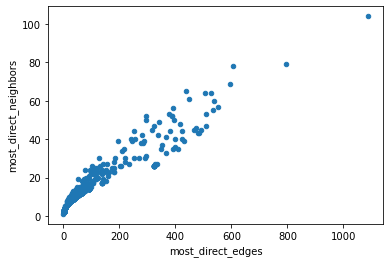

In [243]:
df_node_data.plot(x='most_direct_edges', y='most_direct_neighbors', kind='scatter')